In [1]:
"""
main_00_iss.py
Satellite ground track plotting.
Demonstration of satellite ground track plotting. 
Reads in the position vectors in the Earth Centered Inertial or the Earth Centered Earth Fixed Frame, 
converts these to latitude and longitude and plots the location on an equirectangular-projected map.
Author: Ashiv Dhondea, RRSG, UCT.
Date: 05 December 2016
"""

#Cite:
#https://github.com/AshivDhondea/Satellite_Ground_Track_Plotting_Python
    

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
from matplotlib import colors
import matplotlib.patches as patches
import matplotlib as mpl
import pandas as pd

import datetime as dt
import pytz
import aniso8601
from sgp4.earth_gravity import wgs72
from sgp4.io import twoline2rv

#import AstroFunctions as AstFn

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
"""
AstroFunctions.py

Astrodynamics Functions 

(Only a few functions from my original AstroFunctions.py are included here. )

Description:
Various Python functions useful for astrodynamics applications.
Most of these functions are based on Fundamentals of Astrodynamics, Vallado. 4th ed.

Author: Ashiv Dhondea, RRSG, UCT.
Date: 05 December 2016
"""
# ------------------------------------------------------------------------------------------ #
import numpy as np
import math
# ------------------------------------------------------------------------------------------ #
def fnSeconds_To_Hours(time_period):
    """
    Convert from seconds to hours, minutes and seconds.
    
    Date: 16 October 2016
    """
    num_hrs = int(time_period/(60.*60.));
    time_period =time_period - num_hrs*60.*60.;
    num_mins = int(time_period/60.);
    num_secs = time_period - num_mins*60.;
    return num_hrs,num_mins,num_secs # edit: 1/12/16: float division and multiplication

def fn_Convert_Datetime_to_GMST(datetime_object):
    """
    Converts a date and time in the datetime object form
    to GMST.
    
    Date: 05 October 2016
    """
    obj = datetime_object;
    julianday =  fnJulianDate(obj.year,obj.month,obj.day,obj.hour,obj.minute,obj.second);
    theta_GMST =  fn_Calculate_GMST(julianday);
    return theta_GMST # validated with example 3-5 in vallado.
    
def fnZeroTo2Pi(rotangle):
    """
    Wraps angle to fit in [0,2pi).
    Works in [rad] not [deg]
    Date: 7 October 2016
    """
    wrappedangle = rotangle % (2*math.pi);
    return wrappedangle
    
def fnECItoECEF(ECI,theta):
    ECEF = np.zeros([3],dtype=np.float64);
    # Rotating the ECI vector into the ECEF frame via the GST angle about the Z-axis
    ECEF = np.dot(fnRotate3(theta),ECI);
    return ECEF

def fnJulianDate(yr, mo, d, h, m, s):
    """
    Implements Algo 14 in Vallado book: JulianDate
    Date: 05 October 2016
    """
    JD = 367.0*yr - int((7*(yr+ int((mo+9)/12)))/4.0) + int((275.0*mo)/9.0) + d+ 1721013.5 + ((((s/60.0)+m)/60+h)/24.0);
    return JD # validated with example 3-4 in vallado.
    
def fn_Calculate_GMST(JD):
    """
    Calculates the Greenwich Mean Sidereal Time according to eqn 3-47 on page 188 in Vallado.
    Date: 05 October 2016
    Edit: 06 October 2016: CAUTION: theta_GMST is output in [degrees] rather than in [radians], 
    unlike most of the angles in this file.
    """
    T_UT1 = (JD - 2451545.0)/36525.0
    theta_GMST = 67310.54841 + (876600.0*60*60 + 8640184.812866)*T_UT1 + 0.093104 * T_UT1**2 - 6.2e-6 * T_UT1**3;
    
    while theta_GMST > 86400.0:
        theta_GMST = theta_GMST - 86400;

    theta_GMST = theta_GMST/240.0;
    theta_GMST = theta_GMST - 360; # in [deg] not [rad] !!!!!!!!!!!!!!!!!!!!!!!!!!!
    return theta_GMST # validated with example 3-5 in vallado.

def fnRotate3(alpha_rad):
    T = np.array([[ math.cos(alpha_rad),math.sin(alpha_rad),0], 
                  [-math.sin(alpha_rad),math.cos(alpha_rad),0],
                  [                 0,                0,1]],dtype=np.float64);
    return T # Validated against Vallado's example 2-3. 20/06/16

def fnCarts_to_LatLon(R):
    """
    function which converts ECEF position vectors to latitude and longitude
    Based on rvtolatlong.m in Richard Rieber's orbital library on mathwork.com
    
    Note that this is only suitable for groundtrack visualization, not rigorous 
    calculations.
    Date: 18 September 2016
    """
    r_delta = np.linalg.norm(R[0:1]);
    sinA = R[1]/r_delta;
    cosA = R[0]/r_delta;

    Lon = math.atan2(sinA,cosA);

    if Lon < -math.pi:
        Lon = Lon + 2*math.pi;

    Lat = math.asin(R[2]/np.linalg.norm(R));
    return Lat,Lon


In [16]:
lon[9000]

-1.3033724458192282

satellite number
25544
epochyr
2016
epochdays
298.89519381
jdsatepoch
2457686.39519381
epoch
2016-10-24 21:29:04.745184
inclination
51.643
RAAN
131.0922
eccentricity
0.0007174
argument of perigee
106.9148
mean anomaly
32.6949


findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.


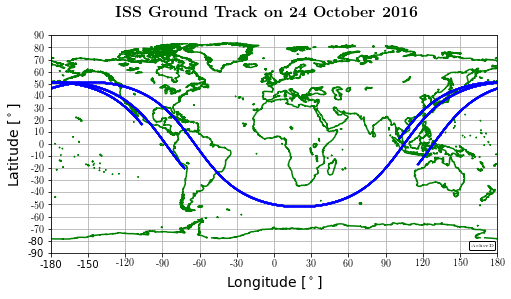

In [4]:
# ------------------------------------------------------------------------------------------------ #
## ISS (ZARYA)             
tle_line1 = '1 25544U 98067A   16298.89519381  .00003992  00000-0  67065-4 0  9991';
tle_line2 = '2 25544  51.6430 131.0922 0007174 106.9148  32.6949 15.54320225 25163';
line1 = (tle_line1);
line2 = (tle_line2);

satellite_obj = twoline2rv(line1, line2, wgs72);
print ('satellite number')
print (satellite_obj.satnum)
print ('epochyr')
print (satellite_obj.epochyr)
print ('epochdays')
print (satellite_obj.epochdays)
print ('jdsatepoch')
print (satellite_obj.jdsatepoch)
print ('epoch')
print (satellite_obj.epoch)
print ('inclination')
print (math.degrees(satellite_obj.inclo))
print ('RAAN')
print (math.degrees(satellite_obj.nodeo))
print ('eccentricity')
print (satellite_obj.ecco)
print ('argument of perigee')
print (math.degrees(satellite_obj.argpo))
print ('mean anomaly')
print (math.degrees(satellite_obj.mo))

delta_t = 1; #[s]
simulation_period = 95*60*2 ;#[s]
timevec = np.arange(0,simulation_period+delta_t,delta_t,dtype=np.float64);
x_state = np.zeros([6,len(timevec)],dtype=np.float64);
xecef = np.zeros([3,len(timevec)],dtype=np.float64);
lat = np.zeros([len(timevec)],dtype=np.float64);
lon = np.zeros([len(timevec)],dtype=np.float64);

index = 0;
current_time = timevec[index];
hrs,mins,secs = fnSeconds_To_Hours(current_time + (satellite_obj.epoch.hour*60*60) + (satellite_obj.epoch.minute*60)+ satellite_obj.epoch.second);
dys = satellite_obj.epoch.day + int(math.ceil(hrs/24));     
if hrs >= 24:
    hrs = hrs - 24*int(math.ceil(hrs/24)) ;
        
satpos,satvel = satellite_obj.propagate(satellite_obj.epoch.year,satellite_obj.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj.epoch.microsecond);
x_state[0:3,index] = np.asarray(satpos);
x_state[3:6,index] = np.asarray(satvel);

tle_epoch_test = dt.datetime(year=satellite_obj.epoch.year,month=satellite_obj.epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
theta_GMST =  math.radians(fn_Convert_Datetime_to_GMST(tle_epoch_test));        
## Rotate ECI position vector by GMST angle to get ECEF position
theta_GMST = fnZeroTo2Pi(theta_GMST);
xecef[:,index] = fnECItoECEF(x_state[0:3,index],theta_GMST);
lat[index],lon[index] = fnCarts_to_LatLon(xecef[:,index]);

for index in range(1,len(timevec)):
    current_time = timevec[index];
    hrs,mins,secs = fnSeconds_To_Hours(current_time + (satellite_obj.epoch.hour*60*60) + (satellite_obj.epoch.minute*60)+ satellite_obj.epoch.second);
    dys = satellite_obj.epoch.day + int(math.ceil(hrs/24)); 
    
    if hrs >= 24:
        hrs = hrs - 24*int(math.ceil(hrs/24)) ;
        
    satpos,satvel = satellite_obj.propagate(satellite_obj.epoch.year,satellite_obj.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj.epoch.microsecond);
    x_state[0:3,index] = np.asarray(satpos);
    x_state[3:6,index] = np.asarray(satvel);

    tle_epoch_test = dt.datetime(year=satellite_obj.epoch.year,month=satellite_obj.epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
    theta_GMST =  math.radians(fn_Convert_Datetime_to_GMST(tle_epoch_test));        
    ## Rotate ECI position vector by GMST angle to get ECEF position
    theta_GMST = fnZeroTo2Pi(theta_GMST);
    xecef[:,index] = fnECItoECEF(x_state[0:3,index],theta_GMST);
    lat[index],lon[index] = fnCarts_to_LatLon(xecef[:,index]);

# ------------------------------------------------------------------------------------------------------------------------------------------------------------ #
## plot results     
coastline_data= np.loadtxt('/home/jovyan/work/Satellite_Ground_Track_Plotting_Python/Coastline.txt',skiprows=0)
#coastline_data= pd.read_csv("/home/jovyan/work/Satellite_Ground_Track_Plotting_Python/Coastline.txt")
w, h = plt.figaspect(0.5)
fig = plt.figure(figsize=(w,h))
ax = fig.gca()
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
plt.rc('font',family='helvetica');
params = {'legend.fontsize': 8,
    'legend.handlelength': 2}
plt.rcParams.update(params)

groundtrack_title = satellite_obj.epoch.strftime('%d %B %Y')
fig.suptitle(r"\textbf{ISS Ground Track on %s}" %groundtrack_title,fontsize=16)
plt.plot(coastline_data[:,0],coastline_data[:,1],'g');
ax.set_xlabel(r'Longitude $[\mathrm{^\circ}]$',fontsize=14)
ax.set_ylabel(r'Latitude $[\mathrm{^\circ}]$',fontsize=14)
plt.xlim(-180,180);
plt.ylim(-90,90);
plt.yticks([-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90]);
plt.xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]);

for index in range(0,len(timevec)):
    plt.plot(math.degrees(lon[index]),math.degrees(lat[index]),'b.',markersize=1);

ax.grid(True);
at = AnchoredText("AshivD",prop=dict(size=5), frameon=True,loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
fig.savefig('main_00_iss_ground_track.pdf',format='pdf',bbox_inches='tight',pad_inches=0.01,dpi=1200);